## 2. Learning a PCFG from a Treebank 

### 2.1. Random PCFG Generation

In [1]:
import nltk
from nltk.grammar import Nonterminal
from nltk.grammar import toy_pcfg2
from nltk.probability import DictionaryProbDist


def pcfg_generate(grammar):
    start = grammar.start()
    items =  pcfg_generate_one(grammar, start)
    tree = pcfg_generate_all(grammar, start, items)
    return tree


def pcfg_generate_all(grammar, item, items):
    if all(isinstance(ter, str) for ter in items):
        tree = (item,) + items

    elif all(isinstance(ter, Nonterminal) for ter in items):
        subtrees = ()
        for ter in items:
            prods = pcfg_generate_one(grammar, ter)
            subtree = pcfg_generate_all(grammar,ter, prods)
            if len(subtrees) == 0:
                subtrees = subtree
            else:
                subtrees = subtrees, subtree
        if len(items) > 1:
            tree = (item,) + subtrees
        else:
            tree = item, subtrees
    else:
        print("MY thesis go wrong")
    return tree 
        
def pcfg_generate_one(grammar, item):
    prod = grammar.productions(item)
    dict = {}
    for pr in prod:
        dict[pr.rhs()] = pr.prob()
    probdist = DictionaryProbDist(dict)
    return probdist.generate()

In [2]:
grammar = toy_pcfg2
pcfg_generate(grammar)

(S, (NP, (Name, 'Jack')), (VP, (V, 'ate')))

#### validation 

#### 2.1.1

In [3]:
f = open("toy_pcfg2.gen", "w")
for i in range(1000):
    tree = pcfg_generate(grammar)
    if i < 999:
        f.write(str(tree) + '\t')
    else: 
        f.write(str(tree))
f.close()

#### 2.1.2

In [6]:
from nltk.grammar import Production, PCFG
from nltk.grammar import  ProbabilisticProduction
from nltk import Tree, Nonterminal

def from_tree_to_pcfg(tree, lcount, pcount):
    prod = tree.productions()
    for p in prod:
        lcount[p.lhs()] = lcount.get(p.lhs(), 0) + 1
        pcount[p] = pcount.get(p, 0) + 1

def from_trees_to_pcfg():
    f = open("toy_pcfg2.gen", "r")
    lcount = {}
    pcount = {}
    for tree in f.read().split('\t'):
        tree = tree.replace(',', '')
        tree = tree.replace('\'', '')
        tree = Tree.fromstring(tree)
        from_tree_to_pcfg(tree, lcount, pcount)
    prods = [
        ProbabilisticProduction(p.lhs(), p.rhs(), prob=pcount[p] / lcount[p.lhs()])
        for p in pcount
    ]
    return prods


p = from_trees_to_pcfg()
print(p)

[S -> NP VP [1.0], NP -> NP PP [0.303398], NP -> Name [0.282767], Name -> 'Bob' [0.479828], PP -> P NP [1.0], P -> 'under' [0.399369], NP -> Det N [0.413835], Det -> 'a' [0.312023], N -> 'cookie' [0.140762], Name -> 'Jack' [0.520172], P -> 'with' [0.600631], Det -> 'the' [0.410557], N -> 'table' [0.129619], VP -> V NP [0.59292], V -> 'ate' [0.509], N -> 'hill' [0.510264], Det -> 'my' [0.277419], V -> 'saw' [0.213], VP -> V [0.390364], V -> 'ran' [0.278], N -> 'telescope' [0.122581], VP -> VP PP [0.0167158], N -> 'boy' [0.0967742]]


#### 2.1.3

In [72]:
import collections

def dict_with_rhs_sets(P):
    dic = {}
    for p in P:
        dic[p.lhs()] = set()
    for p in P:
        dic[p.lhs()].update(p.rhs())
    return dic

def dict_with_p_sets(P):
    dic = {}
    for p in P:
        dic[p.lhs()] = set()
    for p in P:
        dic[p.lhs()].update([p])
    return dic

def smooth_prods(P, Q, eps = 1e-10): ## params: P Q lists of Productions in any kind
    dicp = dict_with_rhs_sets(P)
    dicq = dict_with_rhs_sets(Q)
    dic_p = dict_with_p_sets(P)
    dic_q = dict_with_p_sets(Q)
    p_2_n = []
    q_2_n = []
    for k in dicp:
        if k in dicq:
            p_2_n += smooth_prod(k, dic_p[k], dicq[k]-dicp[k], eps)
        else: 
            print(k)
    for k in dicq:
        if k in dicp:
            q_2_n += smooth_prod(k, dic_q[k], dicp[k]-dicq[k], eps)
    return p_2_n, q_2_n 


def smooth_prod(lhs, P, q_m_p, eps):
    p_2_n = []
    pc = (len(q_m_p)/len(P)) * eps
    p_2_n += [ProbabilisticProduction(q.lhs(), q.rhs(), prob = q.prob()-pc) for q in P]
    p_2_n +=[ProbabilisticProduction(lhs, [p], prob = eps) for p in q_m_p if isinstance(p, Nonterminal)]
    ##p_2_n += [ProbabilisticProduction(lhs, [p], prob = eps) for p in q_m_p if isinstance(p, Nonterminal)]
    return p_2_n



In [68]:
Q = grammar.productions()
print(Q)
print('number of rules in the toy_pcfg2 grammar: ' + str(len(Q)))

[S -> NP VP [1.0], VP -> V NP [0.59], VP -> V [0.4], VP -> VP PP [0.01], NP -> Det N [0.41], NP -> Name [0.28], NP -> NP PP [0.31], PP -> P NP [1.0], V -> 'saw' [0.21], V -> 'ate' [0.51], V -> 'ran' [0.28], N -> 'boy' [0.11], N -> 'cookie' [0.12], N -> 'table' [0.13], N -> 'telescope' [0.14], N -> 'hill' [0.5], Name -> 'Jack' [0.52], Name -> 'Bob' [0.48], P -> 'with' [0.61], P -> 'under' [0.39], Det -> 'the' [0.41], Det -> 'a' [0.31], Det -> 'my' [0.28]]
number of rules in the toy_pcfg2 grammar: 23


The number of rules in this toy grammar is very low, we can expect to fully understand it  while reading 1000 trees that it's generate.

In [60]:
p_n, q_n = smooth_prods(p, Q)

In [61]:
import math
## params: P:= list(Production), Q:= list(Production), all the productions must be in both lists
def KL_divergences(P, Q):
    dicp = dict_with_p_sets(P)
    dicq = dict_with_p_sets(Q)
    kls = []
    for k in dicp:
        if k in dicq:
            kls.append(KL_divergence(dicp[k], dicq[k]))
        else:
            kls.append(math.inf)
    return kls

def KL_divergence(P, Q):
    kl = 0
    for p in P:
        for q in Q:
            if p.lhs() == q.lhs() and p.rhs() == q.rhs():
                kl += p.prob()*(math.log(p.prob())-math.log(q.prob()))
    return kl

print(KL_divergences(p_n, q_n))

[0.0, 0.00010231040115721637, 5.9038804549424884e-08, 0.0, 0.00018394995638364164, 1.8897047505133432e-05, 0.003766590437115344, 0.001996509654262641, 2.9468211797414184e-05]


As we can see, the kl divergence of all the distributions very low, what means that 1000 trees give us a good understanding on the toy_pcfg2 grammar. If the result was totaly high, our main suspect were the procedure generate of DictionaryProbDist class.

### 2.2 Learn a PCFG from a Treebank 

In [4]:
from nltk import corpus
from nltk.corpus import LazyCorpusLoader, BracketParseCorpusReader

def simplify_functional_tag(tag):
    if '-' in tag:
        tag = tag.split('-')[0]
    return tag

treebank = LazyCorpusLoader('treebank/combined', BracketParseCorpusReader, r'wsj_.*\.mrg')

def pcfg_learn(treebank, n):
    pcount = {}
    lcount = {}
    num_of_int_node = 0
    for i in range(n):
        tree = treebank.parsed_sents()[i]
        prods = tree_to_productions(tree)
        for p in prods:
            pcount[p] = pcount.get(p, 0) + 1
            lcount[p.lhs()] = lcount.get(p.lhs(), 0) + 1
            num_of_int_node += 1
    productions = [ProbabilisticProduction(p.lhs(), p.rhs(), prob=pcount[p] / lcount[p.lhs()])
        for p in pcount]
    freqs = [pcount[p] for p in pcount]
    return freqs, PCFG(Nonterminal('S'), productions), num_of_int_node
        
def get_tag(tree):
    if isinstance(tree, Tree):
        return Nonterminal(simplify_functional_tag(tree.label()))
    else:
        return tree

def tree_to_production(tree):
    return Production(get_tag(tree), [get_tag(child) for child in tree])

def tree_to_productions(tree):
    yield tree_to_production(tree)
    for sub in tree.subtrees():
        for n, child in enumerate(sub):
            if isinstance(child, Tree):
                if len(list(child.subtrees(filter=lambda x:x.label()=='-NONE-')))==len(child.leaves()):
                    continue
                else:
                    for prod in tree_to_productions(child):
                        yield prod

In [63]:
n = 200
freqs,  pcfg, int_nodes  = pcfg_learn(treebank, n)
print('number of rules learned from the trees: ' + str(len(pcfg.productions())))
print('number of interior nodes in the trees: ' + str(int_nodes))

number of rules learned from the trees: 2279
number of interior nodes in the trees: 6817931


In this grammar, the number of rules is huge, even after simplifying the labels it's a lot of rules to learn. Every word require a rule for itself, so we can expect that the graph of frequency against number of productions will be high at the lowest frequencies and then a long tail to the highest frequencies, for rules like S->NP VP.

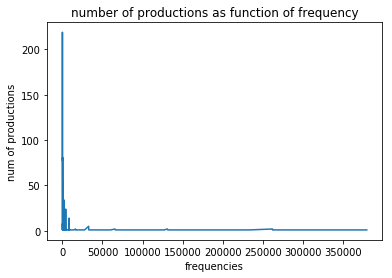

In [64]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

dic = {}

for count in freqs:
    dic[count] = dic.get(count, 0) + 1

xs = [key for key in dic]
xs.sort()
ys = [dic[key] for key in xs]
plt.plot(xs, ys)
plt.xlabel('frequencies')
plt.ylabel('num of productions')
plt.title('number of productions as function of frequency')
plt.show()

In [73]:
n = 400
freqs2, pcfg2, nodes = pcfg_learn(treebank, n)
prods1, prods2 = smooth_prods(pcfg.productions(), pcfg2.productions())
print(KL_divergences(prods1, prods2))

[0.033954389056471516, 0.793194019567361, 1.0606208634831755, 0.0, 1.946802571878097, 2.3488918483832624, 1.2461763464297109, 1.153734762015568, 1.3242852103933824, 0.36837523498872243, 2.087922418006932, 0.0696331006787771, 1.572119514953029, 0.10786007917919527, 0.573656871649484, 0.013220211326812689, 0.05425532963470421, 1.7957962443017434, 0.007722045993138026, 0.0024712112264871867, 3.295964804254622, 1.1468252984966856, 0.0, 0.6953795268875227, 1.365019347009562, 0.0, 0.03205966447668776, 0.26113659823317875, 0.006401111241060422, 1.0745365628335548, 0.019959450407387364, 0.009569790851157625, 0.16771825922554887, 0.0042849538149662405, 0.17689524389355593, 0.7109017762235189, 0.13099732374194836, 8.73485278581015e-05, 0.00042834568863916686, 0.008408784451078816, 0.00045257818957941773, 0.002470235386361803, 0.19675820911521086, 0.0015941374387568592, 0.27401589475242033, 0.0003544582153860044, 0.0, 0.06091720921122472, 0.055105203511372915, 0.005005888366938814, 2.251291795740

### 2.3 Induce a PCFG in Chomsky Normal Form

In [2]:
def pcfg_cnf_learn(treebank, n_range = (0, 150)):
    pcount = {}
    lcount = {}
    int_nodes = 0
    for i in range(n_range[0], n_range[1]):
        tree = treebank.parsed_sents()[i]
        Tree.chomsky_normal_form(tree, factor='right', horzMarkov=1, vertMarkov=1, childChar='|', parentChar='^')
        prods = tree_to_productions(tree)
        for p in prods:
            pcount[p] = pcount.get(p, 0) + 1
            lcount[p.lhs()] = lcount.get(p.lhs(), 0) + 1
            int_nodes += 1
    productions = [ProbabilisticProduction(p.lhs(), p.rhs(), prob=pcount[p] / lcount[p.lhs()])
        for p in pcount]
    freqs = [pcount[p] for p in pcount]
    return freqs, PCFG(Nonterminal('S'), productions), int_nodes

In [113]:
cnf_freqs, cnf_pcfg, int_nodes = pcfg_cnf_learn(treebank, 150)
print('number of rules learned from the CNF trees: ' + str(len(cnf_pcfg.productions())))
print('number of interior nodes in the CNF trees: ' + str(int_nodes))

number of rules learned from the CNF trees: 2491
number of interior nodes in the CNF trees: 148990360


### 2.4: Test CFG Independence Assumptions 

In [140]:
import numpy as np

def dist_of_one_LHS(treebank = treebank, child_filt = lambda x: isinstance(x, Tree) and 'NP' in x.label() , father_filt  = lambda x: True, n = 100):
    pcount = {}
    lcount = {}
    prod_s = []
    for i in range(n):
        tree = treebank.parsed_sents()[i]
        prods = tree_to_spec_prod(tree, child_filt, father_filt)
        flat(prods, prod_s)
        for p in prod_s:
            pcount[p] = pcount.get(p, 0) + 1
            lcount[p.lhs()] = lcount.get(p.lhs(), 0) + 1
        prod_s = []
    productions = [ProbabilisticProduction(p.lhs(), p.rhs(), prob=pcount[p] / lcount[p.lhs()])
        for p in pcount]
    return productions

def flat(l, s):
    for item in l:
        if isinstance(item, list):
            flat(item, s)
        else:
            s.append(item)

def tree_to_spec_prod(tree, child_filt, father_filt):
    prods = []
    if isinstance(tree, Tree):
        if father_filt(tree):
            prods.append([node_to_prod(node) for node in tree if child_filt(node)])
        prods.append([tree_to_spec_prod(child, child_filt, father_filt) for child in tree])
    return prods
    
def node_to_prod(node):
    return Production(get_tag(node), [get_tag(child) for child in node])

def draw_hist(productions):
    labels = [p.rhs() for p in productions]
    values = [p.prob() for p in productions]
    indSort = np.argsort(values)[::-1]
    labels = np.array(labels)[indSort]
    values = np.array(values)[indSort]
    indexes = np.arange(len(labels))
    bar_width = 0.05
    plt.bar(indexes, values)
    plt.xticks(indexes + bar_width, labels)
    plt.xlabel('production')
    plt.ylabel('probability')
    plt.show()

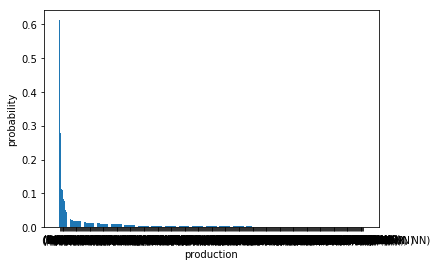

In [141]:
all_NP = dist_of_one_LHS()
draw_hist(all_NP)

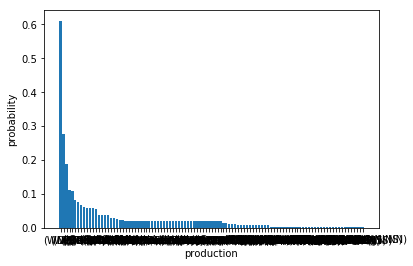

In [142]:
below_S = dist_of_one_LHS(father_filt = lambda x: isinstance(x, Tree) and 'S' in x.label())
draw_hist(below_S)

In [143]:
below_S, all_NP = smooth_prods(below_S, all_NP)
print(KL_divergences(below_S, all_NP))

[0.44446372864903927, 1.065351522926016, 0.0]


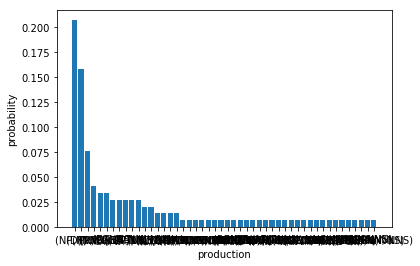

In [144]:
below_VP = dist_of_one_LHS(father_filt = lambda x: isinstance(x, Tree) and 'VP' in x.label())
draw_hist(below_VP)

In [145]:
below_VP, all_NP = smooth_prods(below_VP, all_NP)
print(KL_divergences(below_VP, all_NP))

[0.5635278489950247]


In [1]:
below_VP, below_S = smooth_prods(below_VP, below_S)
print(KL_divergences(below_S, below_VP))

NameError: name 'smooth_prods' is not defined